+++
notebook = true
title = "LargeDeformations: Torsion of a hyperelastic bar"
date = "2023-03-02"
author = "Thomas Nagel"
web_subsection = "large-deformations"
+++


<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./Torsion_robustness.ipynb" download="Torsion_robustness.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=Torsion_robustness.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/LargeDeformation/Torsion/Torsion_robustness.py"><img src="https://img.shields.io/static/v1?label=Source:&message=Torsion_robustness.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/LargeDeformation/Torsion/Torsion_robustness.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

|<div style="width:330px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:330px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e8/TUBAF_Logo.svg" width="300"/></div>|
|---|---|--:|

## Convergence under large deformations (preliminary)

In this benchmark we impose large tensile and torsional deformations on a hyperelastic prismatic bar.
The material model is a Saint-Venant-Kirchhoff material law for initial testing.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pandas as pd
import pyvista as pv
from ogstools import logparser

In [2]:
pv.set_jupyter_backend("static" if "CI" in os.environ else "client")

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [3]:
model = ot.Project(input_file="bar1to6_torsion.prj", output_file="bar1to6_torsion.prj")
model.run_model(logfile=out_dir / "out.txt", args=f"-o {out_dir}")
mesh = ot.MeshSeries(out_dir / "bar1to6_torsion.pvd")[-1]

Project file written to output.
Simulation: bar1to6_torsion.prj
Status: finished successfully.
Execution took 3.6319100856781006 s


## Boundary conditions

The bar of dimensions $1 \times 1 \times 6$ m³ is stretched by $\lambda = 1.5$ in the axial direction and twisted by 180°.
The following graph illustrates the torsion bc.

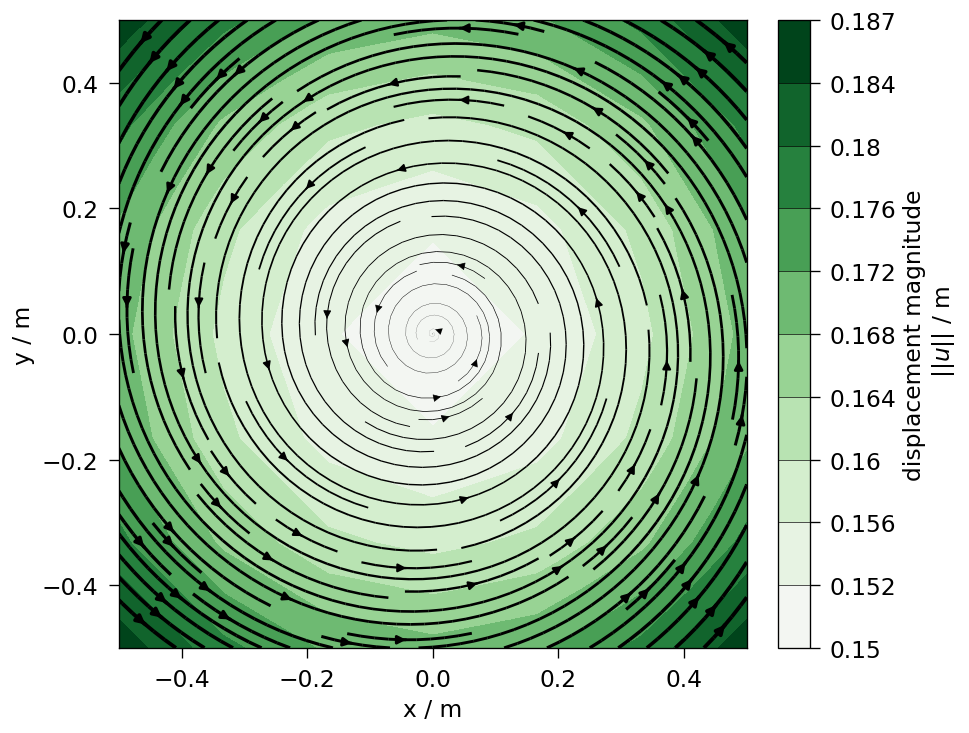

In [4]:
top_pts = mesh.points[:, 2] == mesh.bounds[5]
top_surf = mesh.extract_points(top_pts, False, False).delaunay_2d()
fig = ot.plot.contourf(top_surf, ot.variables.displacement, figsize=(8, 6), fontsize=14)

Let's plot the result.

2025-10-30 14:43:43.827 (   5.297s) [    7F89B7873400]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


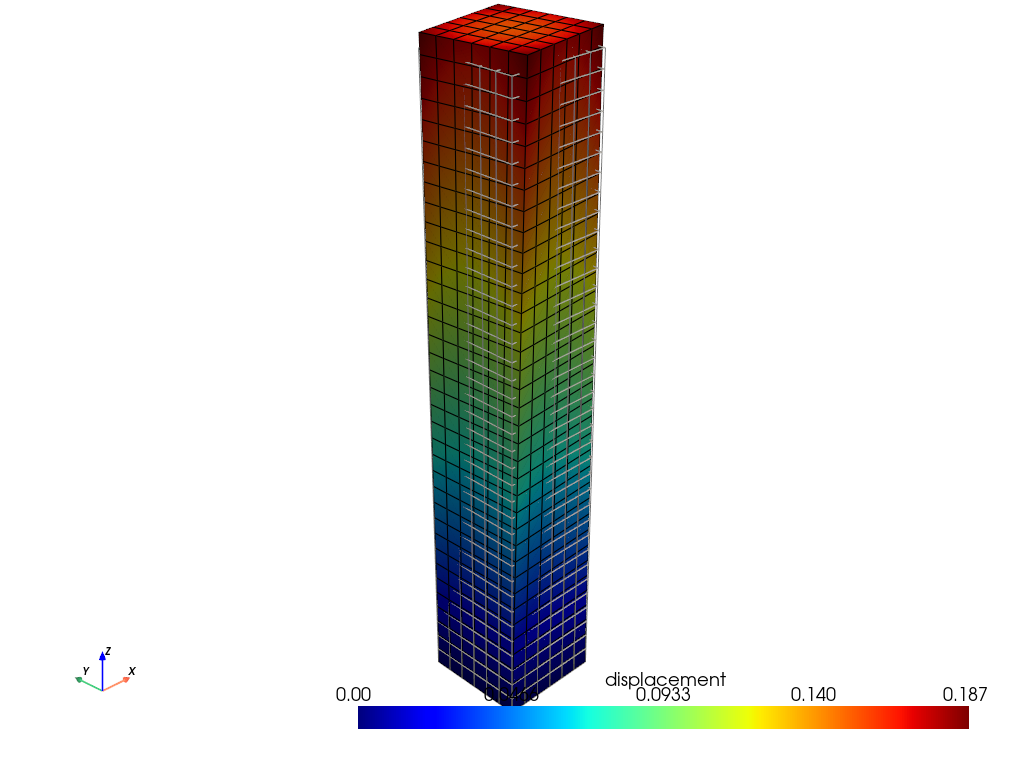

In [5]:
pl = pv.Plotter()
pl.camera_position = (-0.5, -0.5, 0.4)
pl.add_mesh(mesh, color="lightgrey", style="wireframe", line_width=1)
deformed_mesh = mesh.warp_by_vector("displacement")
pl.add_mesh(deformed_mesh, scalars="displacement", show_edges=True, cmap="jet")
pl.show_axes()
pl.reset_camera()
pl.show()

## Convergence

What we're more interested in, is the convergence behaviour over time.
The large deformations were applied in only 5 load steps to challenge the  algorithm.

In [6]:
log_file_raw = logparser.parse_file(f"{out_dir}/out.txt")
log_df = pd.DataFrame(log_file_raw)
for ts in range(1, 6):
    dxs = log_df[log_df["time_step"] == ts]["dx"].dropna().to_numpy()
    slopes = np.log10(dxs)[1:] / np.log10(dxs)[:-1]
    # not checking slope of last ts (below quadratic due to precision limit)
    assert np.all(slopes[:-1] > 1.9)

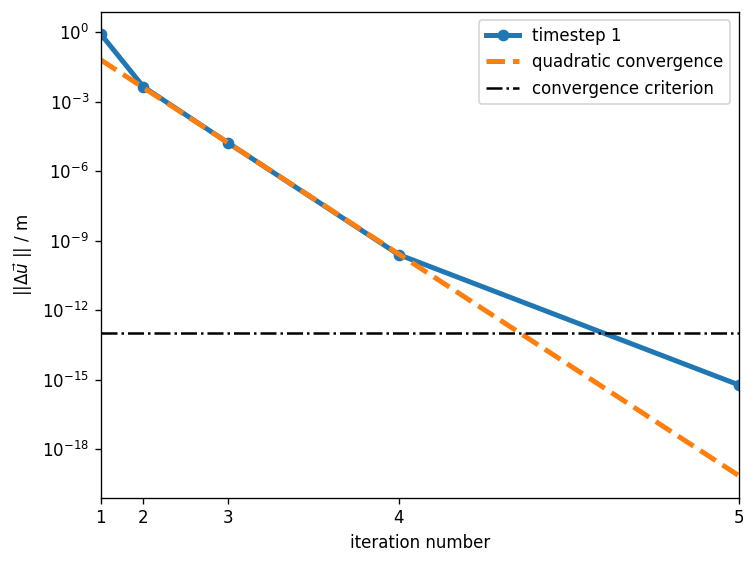

In [7]:
fig, ax = plt.subplots(dpi=120)
ts1_df = log_df[log_df["time_step"] == 1]
its, dxs = ts1_df[["iteration_number", "dx"]].dropna().to_numpy(float).T
ax.plot(its, dxs, "-o", label="timestep 1", lw=3)

offset = 3 - np.log2(-np.log10(dxs[2]))  # to touch the data at dx(it=3)
quad_slope = 10 ** -(2 ** (its - offset))
ax.plot(its, quad_slope, "--C1", lw=3, label="quadratic convergence")

ax.axhline(1e-13, ls="-.", color="k", label="convergence criterion")
ax.set_xscale("function", functions=(lambda x: 2**x, lambda x: np.log10(x - 2)))
ax.set_yscale("log")
ax.set_xlim([1, 5])
ax.set_xticks(its)
ax.set_xlabel("iteration number")
ax.set_ylabel("$|| \\Delta \\vec{u}$ || / m")
ax.legend()
fig.tight_layout()

We observe quadratic convergence in the proximity of the solution supporting the implementation of the geometric stiffness matrix.
The last iteration converges slightly less then quadratic since we reach the numerical precision limit at this point.